
# UDACITY  -    Advanced land finding


#### Hiep Truong Cong

# Helper functions

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
import glob

def Plot_Images(images, number_img_per_row, title = None, subtitle = []):
    """
        This function plot an arbitrary number of images
            input: 
                images: a numpy array of images
                title: a title for the plot
    """
    image_number = len(images)
    if image_number == 1:
        plt.title(title)
        if (images[0].ndim == 2) or (images[0].shape[2] == 1):
            plt.imshow(images[0], cmap='gray')
        else:
            plt.imshow(images[0])
    else:
        if image_number % number_img_per_row == 0:
            number_row = image_number / number_img_per_row
        else:
            number_row = image_number / number_img_per_row + 1
        fig, axs = plt.subplots(int(number_row),number_img_per_row, 
                            figsize=(16, 4 * image_number/number_img_per_row))
        if title!=None:
            fig.suptitle(title, fontsize=18)
        axs = axs.ravel()    
        for n in range(0,image_number):
            axs[n].axis('off')
            if images[n].ndim == 2:
                axs[n].imshow(images[n].squeeze(), cmap='gray')
            elif images[n].shape[2] == 1:
                axs[n].imshow(images[n].squeeze(), cmap='gray')
            else:
                axs[n].imshow(images[n])
    plt.show()
    
####################  Preparation functions ###############################

def find_chessbox_corner(img,nx,ny):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.findChessboardCorners(gray, (nx, ny), None)

def draw_and_display_corners(img,corner,nx,ny):
    cv2.drawChessboardCorners(img, (nx, ny), corners, True)
    return img

def draw_polygon_on_image(img,points):
    for i in range(len(points)):
        if i == (len(points) -1):
            point1 = points[i]
            point2 = points[0]
        else:
            point1 = points[i]
            point2 = points[i + 1]
        cv2.line(img,point1,point2,(255,0,0),8)
    return img

def camera_calibration(images):
    objpoints = []
    imgpoints = []
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    for fname in images:
        # read images
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = find_chessbox_corner(img,9,6)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

#################### pipeline functions #####################################

def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def perspective_img_warp(img, M):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

def thresholding_gray_2_bin(gray_img, thresh = (0,255)):
    binary = np.zeros_like(gray_img)
    binary[(gray_img >= thresh[0]) & (gray_img <= thresh[1])] = 1
    return binary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # Return the binary image
    return thresholding_gray_2_bin(absgraddir, thresh = thresh)

def combine_2_binary_images(img1,img2):
    combined_binary = np.zeros_like(img1)
    combined_binary[(img1 == 1) | (img2 == 1)] = 1
    return combined_binary

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def MaskYellowAndWhite(image):
    """
    This function masks 2 colors yellow and white in an image. 
    These 2 colors are very typical for laneline on highways and city roads
    Other colors are filtered out. The yellow or white pixels are preserved
    and converted to gray scale. Pixels in other colors are removed.
    This resulted gray image is the input for the next step - canny edge detection
    """
    # Convert image from BGR to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    # Mask yellow color in BGR color space of the image
    lower_rgb_yellow = np.array([130,130,50], dtype = "uint8") # original (150,150,60)
    upper_rgb_yellow = np.array([255,250,120], dtype = "uint8")
    mask_rgb_yellow = cv2.inRange(image, lower_rgb_yellow, upper_rgb_yellow)
    rgb_y = cv2.bitwise_and(image, image, mask = mask_rgb_yellow).astype(np.uint8)
    # convert to gray scale
    rgb_y = grayscale(rgb_y)
    # Mask white color in BGR color space of the image
    lower_rgb_white = np.array([190,190,190], dtype = "uint8")
    upper_rgb_white = np.array([255,255,255], dtype = "uint8")
    mask_rgb_white = cv2.inRange(image, lower_rgb_white, upper_rgb_white)
    rgb_w = cv2.bitwise_and(image, image, mask = mask_rgb_white).astype(np.uint8)
    rgb_w = grayscale(rgb_w)
    # Mask yellow color in HLS color space 
    lower_hls_yellow = np.array([20,120,80], dtype = "uint8")
    upper_hls_yellow = np.array([45,200,255], dtype = "uint8")
    mask_hls_yellow = cv2.inRange(hls, lower_hls_yellow, upper_hls_yellow)
    hls_y = cv2.bitwise_and(image, image, mask = mask_hls_yellow).astype(np.uint8)
    hls_y = grayscale(hls_y)
    # sum up the filtered images
    gray = cv2.add(rgb_y, rgb_w)
    gray = cv2.add(gray, hls_y)
    return gray

def color_Gradient_Threshold(img, ksize = 3):
    # filter yellow white colors
    Mask = MaskYellowAndWhite(img)
    binary_maskYellowAndWhite = thresholding_gray_2_bin(Mask, thresh =(100,255))
    ######## gradient threshold
    dir_binary = dir_threshold(Mask, sobel_kernel=ksize, thresh=(0.7,1.2))
    # combine gradient and color threshold
    combined_threshold = combine_2_binary_images(binary_maskYellowAndWhite, dir_binary)
#     Plot_Images([img, Mask] , 2,title = 'White and yellow masking')
#     Plot_Images([Mask, binary_maskYellowAndWhite] , 2,title = 'Binary thresholding')
#     Plot_Images([Mask, dir_binary] , 2, title = 'Direction_Gradient_Thresholding')
#     Plot_Images([combined_threshold] , 2, title = 'Color and gradient thresholded image')
    return combined_threshold

def calculate_curvature_offset(binary_warped, 
                                leftx, 
                                lefty, 
                                rightx, 
                                righty,
                                last_left_curverad = None, 
                                last_right_curverad = None,
                                last_offset = None):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    # calclate the curvature of the left line
    if (lefty.size != 0) and (leftx.size != 0):
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        # Calculate the new radius of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    else:
        left_curverad = last_left_curverad
    # calclate the curvature of the right line   
    if (righty.size != 0) and (rightx.size != 0):
        # Fit new polynomials to x,y in world space
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radius of curvature
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    else:
        right_curverad = last_right_curverad
    
    if (rightx.size != 0) and (leftx.size != 0):
        offset = (rightx[-1] + leftx[-1] - binary_warped.shape[1]) / 2 * xm_per_pix * 100
    else:
        offset = last_offset
    
    return left_curverad, right_curverad, offset

def find_lines_in_1st_frame(binary_warped, 
                            last_left_fit = None, 
                            last_right_fit = None, 
                            last_left_curverad = 0.0, 
                            last_right_curverad = 0.0,
                            last_offset = 0.0):
    Detected = True
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[80:midpoint])
    rightx_base = np.argmax(histogram[midpoint:(1180)]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
     
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 4) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    if (lefty.size != 0) and (leftx.size != 0):
        left_fit_new = np.polyfit(lefty, leftx, 2)        
    else:        
        left_fit_new = last_left_fit
        Detected = False

    if righty.size != 0:    
        right_fit_new = np.polyfit(righty, rightx, 2)
    else:
        right_fit_new = last_right_fit
        Detected = False
        
    new_left_curverad, new_right_curverad, new_offset = calculate_curvature_offset(binary_warped, leftx, lefty, rightx, righty,
                                                                      last_left_curverad, last_right_curverad, last_offset)   
    
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds, new_left_curverad, new_right_curverad, new_offset, out_img, Detected

def find_lines(binary_warped, 
                left_fit, 
                right_fit,
                last_left_curverad = 0.0, 
                last_right_curverad = 0.0,
                last_offset = 0.0):
    Detected = True
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if (lefty.size != 0) and (leftx.size != 0):
        left_fit_new = np.polyfit(lefty, leftx, 2)
    else:
        left_fit_new = left_fit
        Detected = False
    if (righty.size != 0) and (rightx.size != 0):
        right_fit_new = np.polyfit(righty, rightx, 2)
    else:
        right_fit_new = right_fit
        Detected = False
    # calculate curvatures and offset
    new_left_curverad, new_right_curverad, new_offset = calculate_curvature_offset(binary_warped, leftx, lefty, rightx, righty,
                                                                      last_left_curverad, last_right_curverad, last_offset)
    
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds, new_left_curverad, new_right_curverad, new_offset, Detected

def visualization(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, Rectangle_img = None):
    nonzero = binary_warped.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    if Rectangle_img.any():
        out_img = Rectangle_img
    else:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.title('Searching window visualization')
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, binary_warped.shape[1])
    plt.ylim(binary_warped.shape[0], 0)
    plt.show()

def margin_visualization(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
    margin = 30
    nonzero = binary_warped.nonzero()
    nonzeroy = nonzero[0]
    nonzerox = nonzero[1]
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.title('Margin visualization')
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, binary_warped.shape[1])
    plt.ylim(binary_warped.shape[0], 0)
    plt.show()

def draw_lane(binary_warped,left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return color_warp

def add_Text_2_img(img,text,position):
    cv2.putText(img,text,position, cv2.FONT_HERSHEY_SIMPLEX, .5,(255,255,0),2,cv2.LINE_AA)
    return img

def write_Curvature_Offset_On_Image(img, left_curverad, right_curverad, offset):
    img = add_Text_2_img(img, 'L_curve: ' + "{:.2f}".format(left_curverad) +' m',(10,15))
    img = add_Text_2_img(img, 'R_curve: ' + "{:.2f}".format(right_curverad) +' m',(10,40))
    img = add_Text_2_img(img, 'Offset: ' + "{:.2f}".format(offset) +' cm',(10,65))
    return img

def Pineline_video(img, M, mtx, dist, Is_1st_Frame = True, 
                   left_fit = [], 
                   right_fit = [],
                   last_left_curverad = 0.0,
                   last_right_curverad = 0.0,
                   last_offset = 0.0):
    # Distortion correction of the input image
    undistorted_img = undistort_img(img, mtx, dist)
    # color and gradient threshold
    thesholded_image = color_Gradient_Threshold(undistorted_img)
    # Perspective transform
    warped_img = perspective_img_warp(thesholded_image, M)
    binary_warped = np.array(warped_img,  dtype = "uint8")
    # finding lines
    if Is_1st_Frame:
        left_fit_new, right_fit_new, left_lane_inds, right_lane_inds, new_left_curverad, new_right_curverad, new_offset, out_img, Detected = find_lines_in_1st_frame(
            binary_warped, last_left_fit = left_fit, last_right_fit = right_fit,
            last_left_curverad = last_left_curverad,
            last_right_curverad = last_right_curverad,
            last_offset = last_offset)
    else:
        left_fit_new, right_fit_new, left_lane_inds, right_lane_inds, new_left_curverad, new_right_curverad, new_offset, Detected = find_lines(binary_warped, 
                                                                                           left_fit, right_fit)
    # Smoothing the curves - later improvement
    
    # draw lane on image
    drawn_lane = draw_lane(binary_warped,left_fit_new, right_fit_new)
    # inverse perspective transform
    inverse_img = perspective_img_warp(drawn_lane, Minv)
    # write information of curvatures and offset on image
    img = write_Curvature_Offset_On_Image(img, new_left_curverad, new_right_curverad, new_offset)
    # combine lane image with the original frame
    result_frame = cv2.addWeighted(img, 1, inverse_img, 0.3, 0)
       
    return left_fit_new,right_fit_new, result_frame, Detected, new_left_curverad, new_right_curverad, new_offset

def Pineline_image(img, M, mtx, dist, thresholds = [],):
    # Distortion correction of the input image
    undistorted_img = undistort_img(img, mtx, dist)
    Plot_Images([img, undistorted_img] , 2,title = 'Original <--> Undistorted')
    # color and gradient threshold
    thesholded_image = color_Gradient_Threshold(undistorted_img)
    Plot_Images([undistorted_img, thesholded_image] , 2,title = 'Undistorted <--> Thresholded')
    # Perspective transform
    warped_img = perspective_img_warp(thesholded_image, M)
    binary_warped = np.array(warped_img,  dtype = "uint8")
    Plot_Images([thesholded_image, binary_warped] , 2,title = 'Thresholded <--> Warped')
    # finding lines
    left_fit_new, right_fit_new, left_lane_inds, right_lane_inds, left_curverad, right_curverad, offset, out_img, Detected = find_lines_in_1st_frame(
            binary_warped)
    
    # Searching window visualization
    visualization(binary_warped, left_fit_new, right_fit_new, left_lane_inds, right_lane_inds, Rectangle_img = out_img)
    # margin visualization
    margin_visualization(binary_warped, left_fit_new, right_fit_new, left_lane_inds, right_lane_inds)
    
    drawn_line = draw_lane(binary_warped,left_fit_new, right_fit_new)
    # inverse perspective transform
    inverse_img = perspective_img_warp(drawn_line, Minv)
    # write information of curvatures and offset on image
    img = write_Curvature_Offset_On_Image(img, left_curverad, right_curverad, offset)
    # combine lines image with the original frame
    result_image = cv2.addWeighted(img, 1, inverse_img, 0.3, 0)
    return result_image

# Camera calibration

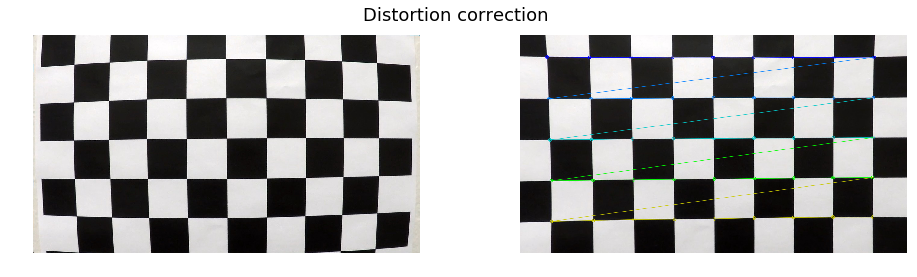

In [6]:
# Read file names of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
# calculate calibration matrices
mtx, dist = camera_calibration(images)
# read one image to calibrate
img_cal = mpimg.imread('./camera_cal/calibration1.jpg')
# calibrate
undist = undistort_img(img_cal, mtx, dist)
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(undist, (9, 5), None)
# Draw corners on the image
cv2.drawChessboardCorners(undist, (9, 5), corners, ret)
# Plot original and calibrated images
Plot_Images([img_cal, undist],2, title = 'Distortion correction')

# Color and gradient thresholding

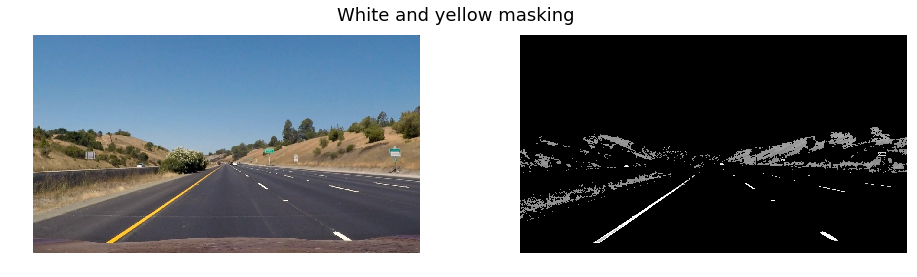

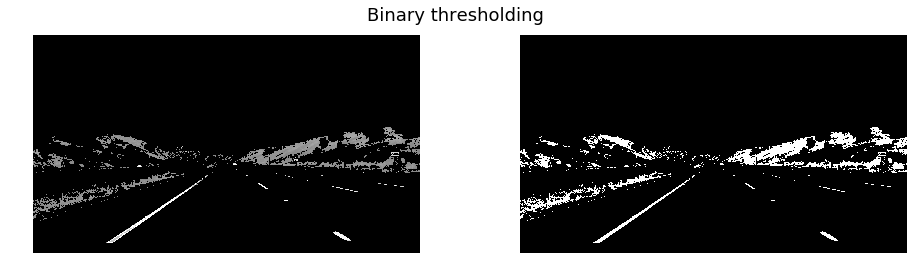

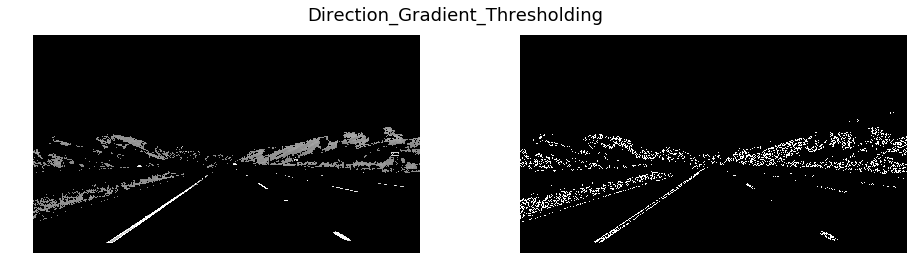

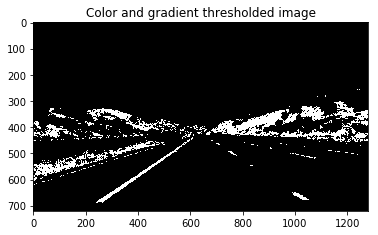

In [11]:
# read 1 test image
image = './test_images/straight_lines1.jpg'
img = mpimg.imread(image)
combined_threshold = color_Gradient_Threshold(img)

# Perspective transformation

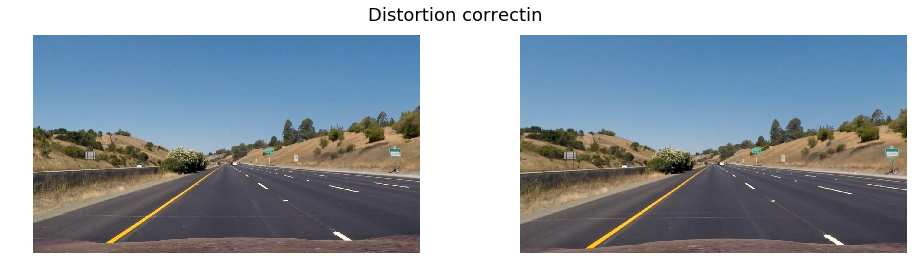

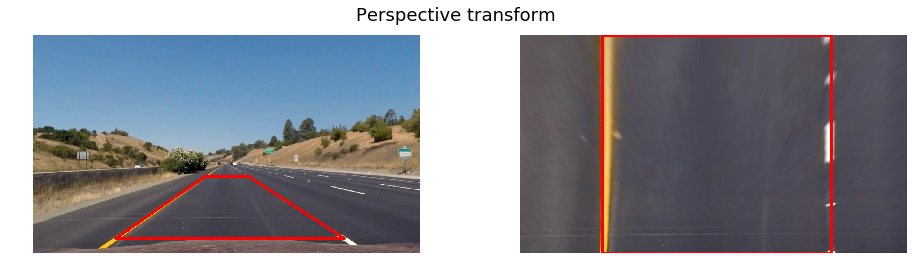

In [3]:
# read 1 test image
image = './test_images/straight_lines1.jpg'
img = mpimg.imread(image)
# Distortion correction of the input image
undistorted_img = undistort_img(img, mtx, dist)
cv2.imwrite('./output_images/undistorted.jpg', undistorted_img)
# Points on distorted image 
src = np.float32([[273,672],[570,466],[712,466],[1030,672]])
# Corresponding points in real world
dst = np.float32([[273,720],[273,0],[1030,0],[1030,720]])
# points to draw contour on source image
src_pts = [(273,672),(570,466),(712,466),(1030,672)]
# points to draw contour on undistorted images
dst_pts = [(273,720),(273,0),(1030,0),(1030,720)]
# get transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# get inverse transform matrix
Minv = cv2.getPerspectiveTransform(dst, src)
# Transform an image
warped = perspective_img_warp(undistorted_img, M)
# Plot original and calibrated images
Plot_Images([img, undistorted_img],2, title = 'Distortion correctin')
undistorted_img = draw_polygon_on_image(undistorted_img, src_pts)
warped = draw_polygon_on_image(warped,dst_pts)
Plot_Images([undistorted_img, warped],2, title = 'Perspective transform')

## Pipeline for images

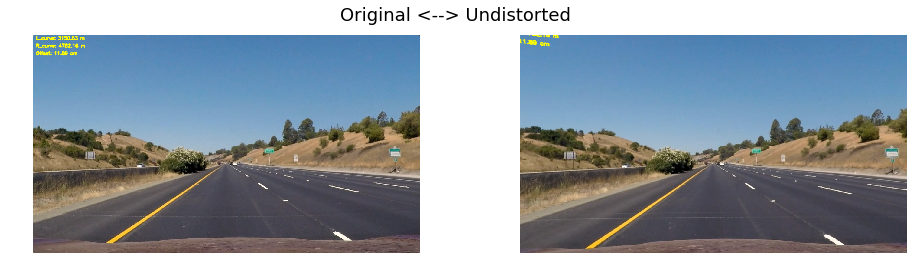

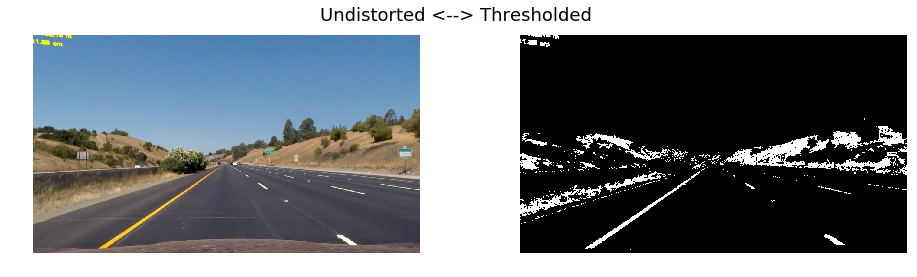

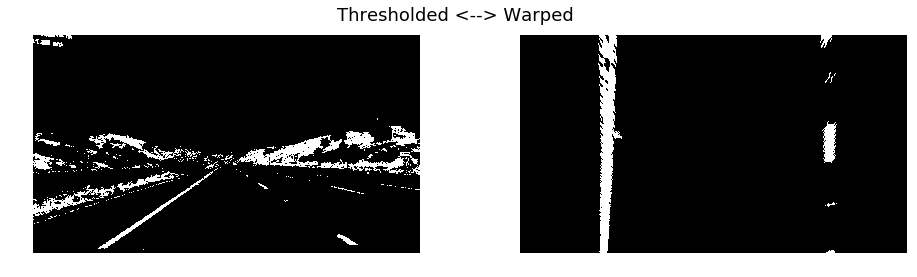

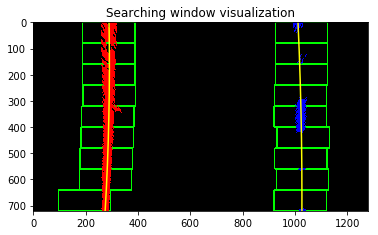

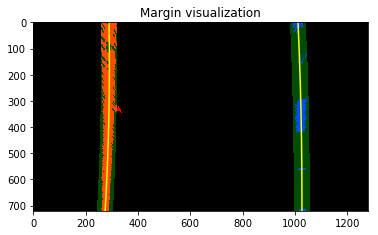

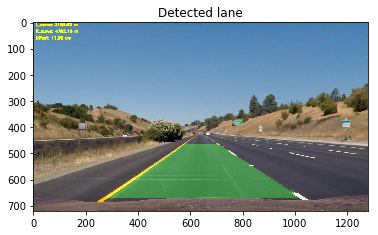

In [5]:
img_p = Pineline_image(img, M, mtx, dist)
Plot_Images([img_p],1, title = 'Detected lane')

## Pipeline for videos

In [7]:
left_fit = []
right_fit = []
last_left_curverad = 0.0
last_right_curverad = 0.0
last_offset = 0.0
Is_1st_Frame = True
frame_number = 0

def process_image(image):
    global frame_number, left_fit, right_fit, last_left_curverad, last_right_curverad, last_offset, Is_1st_Frame
    left_fit, right_fit, img, Detected, new_left_curverad, new_right_curverad, new_offset = Pineline_video(image, M, mtx, dist, 
                                                       Is_1st_Frame = Is_1st_Frame,
                                                       left_fit = left_fit,
                                                       right_fit = right_fit,
                                                       last_left_curverad = last_left_curverad,
                                                       last_right_curverad = last_right_curverad,
                                                       last_offset = last_offset)
    img = add_Text_2_img(img, 'frame: ' + str(frame_number), (10,710))
    img = add_Text_2_img(img, 'Hiep Truong', (1150,710))
    frame_number = frame_number + 1
    Is_1st_Frame = !Detected
    last_left_curverad = new_left_curverad
    last_right_curverad = new_right_curverad
    last_offset = new_offset
    return img

def Processing_video(input_video, output_video):
    clip1 = VideoFileClip(input_video)
    white_clip = clip1.fl_image(process_image)
    %time white_clip.write_videofile(output_video, audio=False)

In [8]:
input_project_video = './test_videos/project_video.mp4'
file_name =  input_project_video.replace('./test_videos/', '')
output_project_video = './output_videos/' + file_name

Processing_video(input_project_video, output_project_video)

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:23<00:00,  4.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

Wall time: 4min 25s


In [9]:
input_challenge_video = './test_videos/challenge_video.mp4'
file_name =  input_challenge_video.replace('./test_videos/', '')
output_challenge_video = './output_videos/' + file_name

Processing_video(input_challenge_video, output_challenge_video)

[MoviePy] >>>> Building video ./output_videos/challenge_video.mp4
[MoviePy] Writing video ./output_videos/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:40<00:00,  5.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/challenge_video.mp4 

Wall time: 1min 41s


# Results

### Project video

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_project_video))

### Challenge video

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_challenge_video))

## Miscellaneous

In [19]:
# Debugging functions
# Extract frames from a video

frames_to_extract = [i for i in range(144,145)]
frame_number = 0

cap = cv2.VideoCapture('./test_videos/challenge_video.mp4')
file_name =  input_video.replace('./test_videos/', '')
file_name =  file_name.replace('.mp4', '')

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        if frame_number in frames_to_extract:
            file_name = './extracted/' + file_name + str(frame_number) + '.jpg'
            cv2.imwrite(file_name, frame)
        frame_number = frame_number + 1
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break  
    else:
        break
